In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import log_loss
import itertools 
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, log_loss
from tqdm import tqdm
from random import sample, randint

In [2]:
path = "/content/drive/MyDrive/datasets/tabular"

In [3]:
submission = pd.read_csv(path + '/sample_submission.csv', index_col='id')
labels = pd.read_csv(path + '/train_labels.csv', index_col='id')

In [ ]:
labels

,label
id,
0,0
1,1
2,1
3,1
4,0
...,...
19995,1
19996,1
19997,0


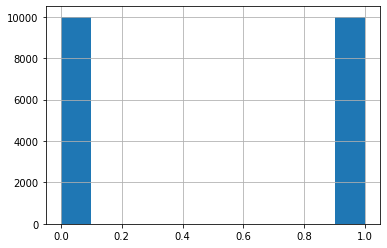

In [ ]:
labels.label.hist()

In [ ]:
submission

,pred
id,
20000,0.640707
20001,0.636904
20002,0.392496
20003,0.588658
20004,0.783603
...,...
39995,0.382515
39996,0.352498
39997,0.577554


In [4]:
# the ids of the submission rows (useful later)
sub_ids = submission.index

# the ids of the labeled rows (useful later)
gt_ids = labels.index 

# list of files in the submission folder
subs = sorted(os.listdir(path))

In [5]:
top100subs = subs

In [ ]:
data_top100 = pd.read_csv(path +"/"+ subs[1], index_col='id')
data_top100 = data_top100.rename(columns={'pred':'pred0'})
for i,top in tqdm(enumerate(top100subs[1:100])):
    df_temp = pd.read_csv(path +"/"+ top, index_col='id')
    df_temp = df_temp.rename(columns={'pred':'pred'+str(i+1)})
    data_top100 = pd.concat([data_top100,df_temp],axis=1)

99it [00:38,  2.54it/s]


In [ ]:
combinations = list(itertools.combinations(data_top100.columns[0:50],5))

In [ ]:
len(combinations)

1906884

In [ ]:
data_top100_fst_half = data_top100.iloc[0:20000]

In [ ]:
best_comb = []
score_best = 1
for comb in tqdm(sample(combinations,10000)):
    loc_comb = sample(comb,randint(2,5))
    temp_mean = data_top100_fst_half[list(loc_comb)].agg('mean',axis=1)
    score_local = log_loss(list(labels.label),list(temp_mean))
    if score_local < score_best:
        best_comb = loc_comb
        score_best = score_local

100%|██████████| 10000/10000 [12:18<00:00, 13.55it/s]


In [ ]:
pred = pd.DataFrame(data_top100[list(best_comb)].agg('mean',axis=1),
                    columns=['pred']
                    ) 
pred.iloc[20000:].to_csv('sub_top50_fst1000.csv')

Calibration

In [62]:
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score

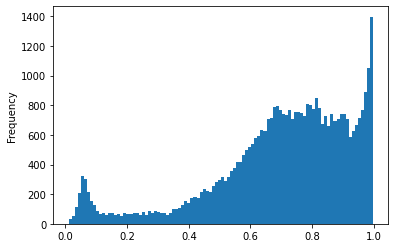

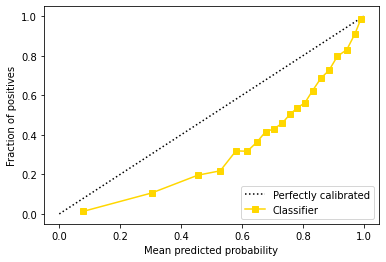

In [57]:
# example of an uncalibrated model prediction on train set
data_top100[:20000]['pred100']
data_top100[:]['pred100'].plot(kind='hist', bins=100)
CalibrationDisplay.from_predictions(labels.label[0:20000], data_top100[0:20000]['pred100'], n_bins=20,
                                        strategy='quantile', color='#ffd700')

514it [00:11, 45.04it/s]


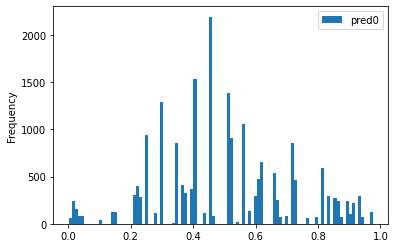

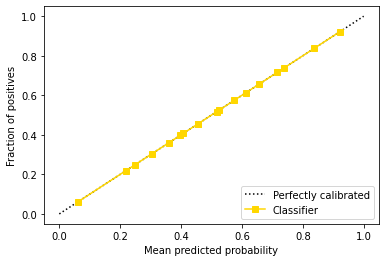

In [63]:
# train set calibration 
roc_auc_scores_calibrated = {}
X_train_calibrated = data_top100.copy()
for i, c in tqdm(enumerate(data_top100.columns)):
    x_model_calibration = np.zeros(40000)
    model_calibration = IsotonicRegression(out_of_bounds='clip')
    x_model_calibration[:20000] = model_calibration.fit_transform(data_top100[:20000][c], labels.label).clip(0.001, 0.999)
    x_model_calibration[20000:] = model_calibration.transform(data_top100[20000:][c]).clip(0.001, 0.999)
    X_train_calibrated[c] = x_model_calibration
    auc_score = roc_auc_score(labels.label[0:20000], x_model_calibration[0:20000])
    roc_auc_scores_calibrated[c]=auc_score
pd.DataFrame(X_train_calibrated[:20000][X_train_calibrated.columns[0]]).plot(kind='hist', bins=100)
CalibrationDisplay.from_predictions(labels.label[0:20000], X_train_calibrated[:20000][X_train_calibrated.columns[0]], n_bins=20,
                                        strategy='quantile', color='#ffd700')

Model

In [6]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 155 kB/s 


In [7]:
from catboost import CatBoostRegressor

In [12]:
data_top100 = pd.read_csv(path +"/"+ subs[1], index_col='id')
data_top100 = data_top100.rename(columns={'pred':'pred0'})
for i,top in tqdm(enumerate(top100subs[1:500])):
    df_temp = pd.read_csv(path +"/"+ top, index_col='id')
    data_top100['pred'+str(i)] = df_temp 

96it [00:03, 45.24it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
499it [00:13, 37.34it/s]


In [14]:
for i in range(0,50,10):
    data_top100['top'+str(i)+'_mean'] = data_top100[data_top100.columns[i:i+10]].agg('mean',axis=1)
    data_top100['top'+str(i)+'_max'] = data_top100[data_top100.columns[i:i+10]].agg('min',axis=1)
    data_top100['top'+str(i)+'_min'] = data_top100[data_top100.columns[i:i+10]].agg('max',axis=1)
# data_top100['top50_median'] = data_top100[data_top100.columns[:50]].agg('median',axis=1)
# data_top100['top50_var'] = data_top100[data_top100.columns[:50]].agg('var',axis=1)
# data_top100['top50_std'] = data_top100[data_top100.columns[:50]].agg('std',axis=1)

In [65]:
df_train = X_train_calibrated.iloc[0:20000]
df_test = X_train_calibrated.iloc[20000:]
# df_train = data_top100.iloc[0:20000]
# df_test = data_top100.iloc[20000:]

In [66]:
# also making train test from df_train
X = df_train[0:15000]
y = labels.label[0:15000]
X_test = df_train[15000:20000]
y_test = labels.label[15000:20000]

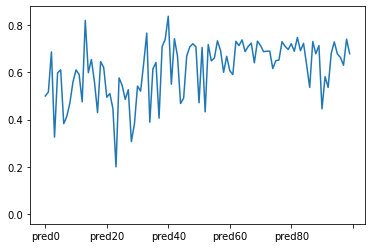

In [67]:
plt.figure()
data_top100[data_top100.columns[0:100]].iloc[100].plot()
plt.plot(y_test.iloc[100])

In [116]:
model = CatBoostRegressor(
    l2_leaf_reg = 0.2,
    learning_rate = 0.009,
    iterations = 1300,
    random_seed = 42,
    depth = 3
)

In [110]:
# grid = {'learning_rate': [0.005, 0.007, 0.01],
#         'iterations': [1300, 1500]}

# randomized_search_result = model.randomized_search(grid,
#                                                    X=X,
#                                                    y=y)

In [109]:
randomized_search_result.params

AttributeError: ignored

In [ ]:
model.get_all_params()

In [117]:
model.fit(X,y,eval_set=(X_test,y_test),verbose=50)

0:	learn: 0.4988306	test: 0.4988532	best: 0.4988532 (0)	total: 28.8ms	remaining: 37.5s
50:	learn: 0.4587900	test: 0.4580857	best: 0.4580857 (50)	total: 1.43s	remaining: 34.9s
100:	learn: 0.4395762	test: 0.4384175	best: 0.4384175 (100)	total: 2.79s	remaining: 33.2s
150:	learn: 0.4304275	test: 0.4290680	best: 0.4290680 (150)	total: 4.12s	remaining: 31.3s
200:	learn: 0.4260336	test: 0.4245325	best: 0.4245325 (200)	total: 5.37s	remaining: 29.4s
250:	learn: 0.4238793	test: 0.4223945	best: 0.4223945 (250)	total: 6.6s	remaining: 27.6s
300:	learn: 0.4227295	test: 0.4212573	best: 0.4212573 (300)	total: 7.83s	remaining: 26s
350:	learn: 0.4220561	test: 0.4206149	best: 0.4206149 (350)	total: 9.02s	remaining: 24.4s
400:	learn: 0.4215819	test: 0.4202489	best: 0.4202489 (400)	total: 10.2s	remaining: 22.9s
450:	learn: 0.4212227	test: 0.4199832	best: 0.4199832 (450)	total: 11.4s	remaining: 21.5s
500:	learn: 0.4209581	test: 0.4198173	best: 0.4198173 (500)	total: 12.5s	remaining: 20s
550:	learn: 0.420688

In [122]:
predicted = model.predict(df_test)

In [118]:
predicted_test = model.predict(X_test)
predicted_train = model.predict(X)

In [119]:
log_loss(y,predicted_train)

0.5139741966009902

In [120]:
log_loss(y_test,predicted_test)

0.5177186533164767

In [ ]:
y_test

In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.2 MB/s 


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_train)

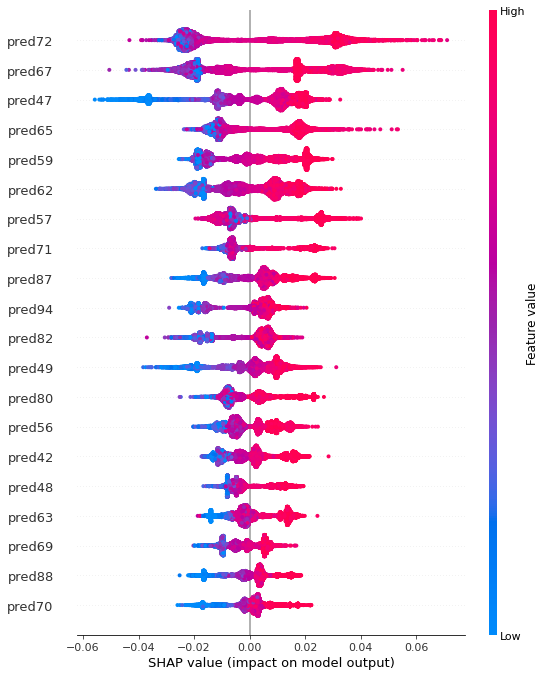

In [ ]:
shap.summary_plot(shap_values, df_train)

In [123]:
pd.DataFrame({'id':range(20000,40000),'pred':predicted}).to_csv('sub_curr.csv',index=False)